<a href="https://colab.research.google.com/github/camlab-bioml/Astir-Vignette/blob/main/astir_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Astir
### Your favourite cell type assignment algorithm for single cell multiplexed imaging and proteomic data.

This is a reproducible notebook with some sample data for you to explore Astir's capability.

In [ ]:
# Install required packages
!pip install git+https://github.com/camlab-bioml/astir.git # installing from github because the pip installation still had the bug I fixed
!pip install anndata
!pip install pyyaml
!pip install scanpy
!pip install MulticoreTSNE

  Cloning https://github.com/camlab-bioml/astir.git to /tmp/pip-req-build-e3r1uxm5
  Running command git clone -q https://github.com/camlab-bioml/astir.git /tmp/pip-req-build-e3r1uxm5
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 133kB 10.3MB/s 
     |████████████████████████████████| 7.1MB 35.2MB/s 
     |████████████████████████████████| 163kB 37.7MB/s 
     |████████████████████████████████| 9.2MB 22.2MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 21.6MB 1.7MB/s 
     |████████████████████████████████| 112kB 38.0MB/s 
     |████████████████████████████████| 92kB 7.3MB/s 
     |████████████████████████████████| 245kB 40.3MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 4.7MB 27.7MB/s 
     |████████████████████████████████| 747kB 17.5MB/s 
     |████████████████████████████████| 7.

     |████████████████████████████████| 10.3MB 5.1MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 1.2MB 20.8MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.4-cp37-none-any.whl size=7899 sha256=42c0c47594c44b0cfbd0f776741ecd61e27f118111ad1ca28165391247725817
  Stored in directory: /root/.cache/pip/wheels/43/a4/e5/d4e0a170ccc134e509ea55acad7845f0fdfa62b964e430f0e3
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=a5ac7d7bdcd10c7acffbd865e3627aba9bf6f0ad269405d28caa601c25a644cf
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=42b1ec0b54c890ed2dc439ef33abfe9364eba8c49ef708a00080a8a6dd560623
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5

## Load some data
First we load some sample IMC data. These data are 50k cells from the Jackson et al. 2020 Nature publication.


As shown below, this is an AnnData object with 50,000 cells and in this case 40 total measured markers.

In [ ]:
import anndata
basel = anndata.read_h5ad("basel_50k_subset.h5ad")
basel

AnnData object with n_obs × n_vars = 50000 × 38
    obs: 'cell_id', 'batch'

## Creating an Astir object
Astir can take single cell expression data as AnnData or loom files with the `from_anndata_yaml` and `from_loompy_yaml` functions. Here we will use the AnnData version.





In [ ]:
from astir.data import from_anndata_yaml

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Next, we need to convert the AnnData object into an Astir object. This also requires a list of marker files for each cell type of interest. 

The marker file should be a yaml file listing the markers that are expected to be overexpressed in each cell type as shown below:

In [ ]:
import yaml

# Read in yaml file for illustration purposes
with open(r'jackson-2020-markers-v4.yml') as file:
  cell_types = yaml.load(file)

  print(cell_types['cell_types'])

{'Stromal': ['Vimentin', 'Fibronectin', 'SMA'], 'B cells': ['CD45', 'CD20'], 'T cells': ['CD45', 'CD3'], 'Epithelial (basal)': ['E-Cadherin', 'pan Cytokeratin', 'Cytokeratin 5', 'Cytokeratin 14'], 'Epithelial (other)': ['E-Cadherin', 'pan Cytokeratin'], 'Epithelial (luminal)': ['E-Cadherin', 'pan Cytokeratin', 'Cytokeratin 7', 'Cytokeratin 8/18', 'Cytokeratin 19'], 'Macrophage': ['CD45', 'CD68'], 'Endothelial': ['vWF', 'Vimentin']}


In [ ]:
ast = from_anndata_yaml("basel_50k_subset.h5ad", "jackson-2020-markers-v4.yml")
ast

## Setting up Astir hyperparameters

Astir takes the following hyperparameters:


*   Batch size
*   Maximum number of epochs
*   A learning rate
*   An initial set of epochs




In [ ]:
# Create batch size proportional to the number of cells
N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)

# Number of training epochs
max_epochs = 1000

# Set learning rate
learning_rate = 2e-3

# Set initial epochs
initial_epochs = 3

To assign cell types simply call `fit_type` as follows.

In [ ]:
ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   4%|▎         | 35/1000 [ 3.29s/epochs, current loss: -740838.3]


Importantly, Astir automatically creates a design matrix based on on additional covariates in the data such as batches. This is done using additional columns already present in the input data. In the example data of this vignette we have included a 'batch' column for the purposes of illustration.

We can get the cell type assignments in one of two ways:
1. Using `get_celltypes()`: this returns the most likely cell type or classifies a cell as unknown if no cell type has a probability above 0.7. (This threshold can be altered by the user with the threshold argument)
2. Using `get_celltype_probabilities()`: this returns the probabilty of each cell being assigned to any given cell type.

In [ ]:
ast.get_celltypes()

,cell_type
BaselTMA_SP41_86_X15Y3_1,Epithelial (other)
BaselTMA_SP41_86_X15Y3_2,Epithelial (other)
BaselTMA_SP41_86_X15Y3_3,Unknown
BaselTMA_SP41_86_X15Y3_4,Unknown
BaselTMA_SP41_86_X15Y3_5,Epithelial (other)
...,...
BaselTMA_SP43_266_X7Y8_1413,Stromal
BaselTMA_SP43_266_X7Y8_1414,Epithelial (luminal)
BaselTMA_SP43_266_X7Y8_1415,Stromal
BaselTMA_SP43_266_X7Y8_1416,Stromal


In [ ]:
ast.get_celltype_probabilities()

,Stromal,B cells,T cells,Epithelial (basal),Epithelial (other),Epithelial (luminal),Macrophage,Endothelial,Other
BaselTMA_SP41_86_X15Y3_1,2.562103e-05,1.470874e-08,2.330556e-05,1.633588e-06,9.999363e-01,8.592978e-07,1.568994e-15,5.171364e-13,1.223282e-05
BaselTMA_SP41_86_X15Y3_2,1.086913e-03,1.612253e-05,2.860566e-03,2.117425e-08,9.947681e-01,1.106801e-07,5.388454e-13,3.098262e-12,1.268194e-03
BaselTMA_SP41_86_X15Y3_3,5.075894e-02,1.084772e-03,3.703190e-01,6.766941e-07,4.399874e-01,8.236305e-08,5.533992e-11,1.601407e-08,1.378491e-01
BaselTMA_SP41_86_X15Y3_4,3.501967e-02,1.297258e-03,6.069886e-01,3.114346e-07,1.074589e-01,3.374483e-09,2.410819e-11,8.368521e-09,2.492353e-01
BaselTMA_SP41_86_X15Y3_5,1.190723e-03,1.463920e-05,4.361109e-03,8.405047e-08,9.926041e-01,1.556828e-07,4.848296e-13,4.268363e-12,1.829149e-03
...,...,...,...,...,...,...,...,...,...
BaselTMA_SP43_266_X7Y8_1413,9.515443e-01,1.898154e-03,2.531302e-02,3.382013e-12,3.085727e-06,2.523147e-16,8.589078e-11,1.591791e-08,2.124147e-02
BaselTMA_SP43_266_X7Y8_1414,3.485011e-23,1.379031e-21,8.001028e-26,3.060548e-19,1.309596e-15,1.000000e+00,9.608637e-22,4.489601e-28,2.274926e-23
BaselTMA_SP43_266_X7Y8_1415,9.923716e-01,7.294215e-06,5.234358e-03,2.386025e-13,1.898557e-07,2.454896e-20,3.976070e-15,5.630232e-11,2.386577e-03
BaselTMA_SP43_266_X7Y8_1416,9.997951e-01,1.296670e-07,6.462700e-05,2.686537e-09,3.346573e-06,9.432820e-20,2.188037e-17,2.365509e-13,1.368003e-04


## Post-fit diagnostics

As a sanity check for the user, Astir also outputs a set of post-fit diagnostics. These ensure that all cell types express their marker proteins at significantly higher levels that other cells. Should this not be the case the markers in question will be highlighted in the `note` column.


In [ ]:
ast.diagnostics_celltype()

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note
0,Vimentin,Stromal,B cells,0.704165,0.762647,1.746017e-03,None
1,Vimentin,Stromal,Macrophage,0.704165,0.916694,2.475672e-09,None
2,Vimentin,Stromal,Other,0.704165,0.597625,5.443175e-01,None
3,CD20,B cells,T cells,0.037191,0.034817,5.318957e-01,None
4,CD20,B cells,Epithelial (basal),0.037191,0.040776,2.239161e-02,None
5,CD20,B cells,Macrophage,0.037191,0.038608,7.027018e-01,None
6,CD20,B cells,Other,0.037191,0.027976,5.788455e-01,None
7,CD3,T cells,Stromal,0.006663,0.012897,7.712442e-06,None
8,CD3,T cells,B cells,0.006663,0.039626,5.468702e-60,None
9,CD3,T cells,Epithelial (basal),0.006663,0.036590,2.476577e-27,None


## Analyzing our data

Now that we have assigned cell types to all cells, we can do some basic analysis.

Let us start with a t-SNE plot coloured by cell type. (This may take a while because it has to run t-SNE first).

In [ ]:
import scanpy
scanpy.tl.tsne(basel, n_pcs = 50)

In [ ]:
basel.obs["cell_type"] = ast.get_celltypes(threshold=0.5)['cell_type']

In [ ]:
from itertools import chain
m_list = [x for x in cell_types['cell_types'].values()]
markers = list(chain.from_iterable(m_list))

markers = list(set(markers))

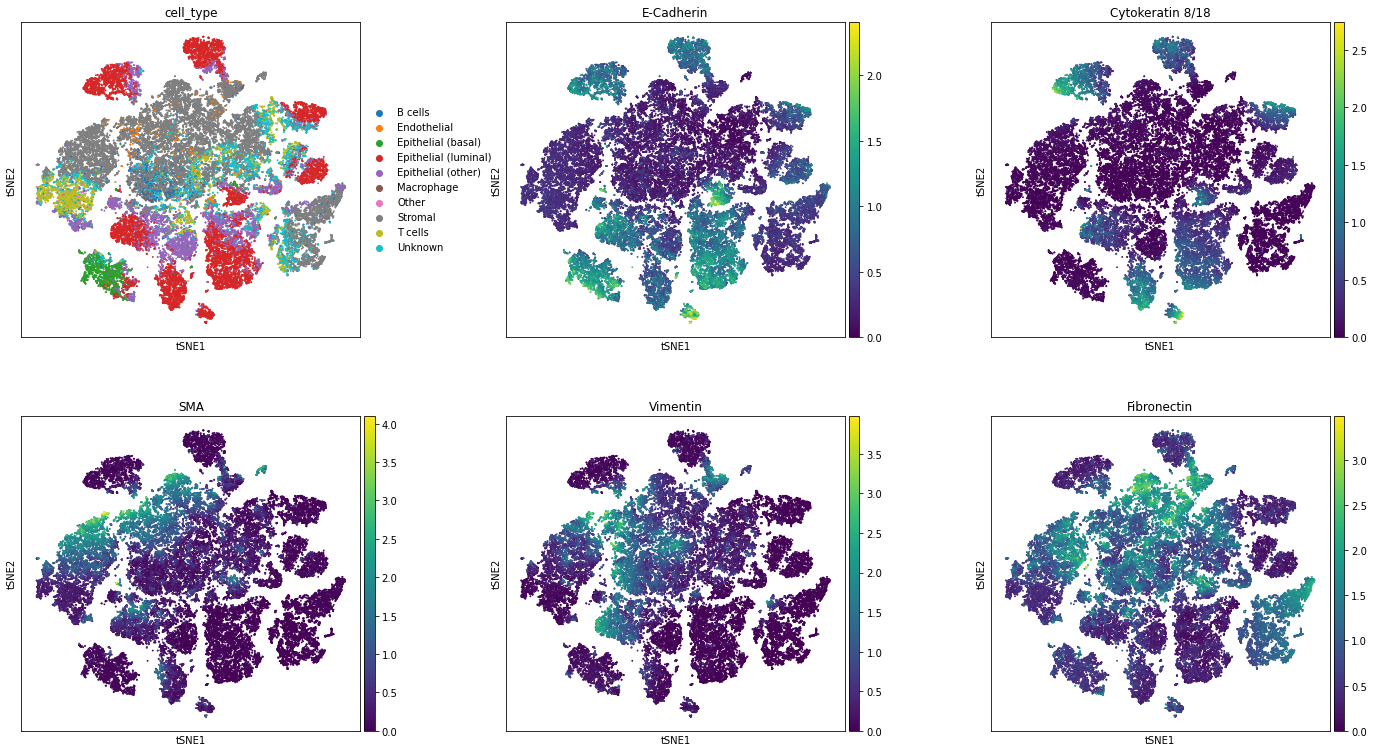

In [ ]:
# color by markers
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
  scanpy.pl.tsne(basel, color = ['cell_type', 'E-Cadherin', 'Cytokeratin 8/18', 'SMA', 'Vimentin', 'Fibronectin'], size = 14, ncols = 3, wspace = 0.3)

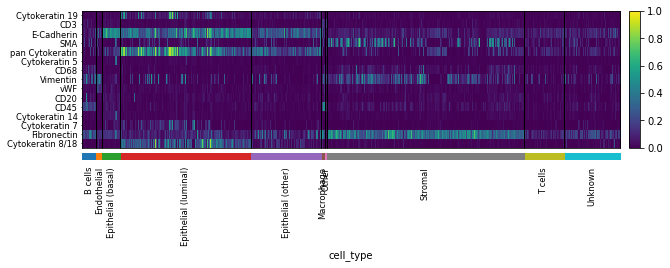

In [ ]:
scanpy.pl.heatmap(basel, markers, groupby='cell_type', swap_axes=True, standard_scale='var')